In [18]:
# Clone the entire repo.
!git clone -l -s https://github.com/moheb432/principles-of-smile.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 4779, done.
remote: Total 4779 (delta 0), reused 0 (delta 0), pack-reused 4779
Receiving objects: 100% (4779/4779), 276.91 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (263/263), done.
Checking out files: 100% (4875/4875), done.
/content/cloned-repo/cloned-repo
 add_augmented_to_csv.py		 mobile-net.ipynb
 all_teeth				 old
'biometrics_dataset - Sheet1.csv'	 README.md
 Copy_of_biometrics_task_model_1.ipynb	 resize_with_padding.py
 data_augmentation.py			 smile_dataset
 dataset_2_almid.xlsx			'teeth_not cropped'
 dataset_5_classes.csv			 Untitled.ipynb
 dataset_and_augmented.csv		 vgg.ipynb
 dataset.csv				 vgg_transfer_faces.ipynb
 dataset_split.ipynb			 vgg_transfer_padded_faces.ipynb
 Dlib-68-face-landmark.png		 vgg_transfer_padded_teeth.ipynb
 faces					 vgg_transfer_teeth.ipynb
 faces+teeth				 weight_converting.ipynb
 images_preprocessing.py		 weights.hkl


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from tensorflow import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.models import Sequential
from keras.layers.convolutional import ZeroPadding2D
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

## 1- load Images dataset

In [21]:
def append_ext(fn):
    return str(fn)+".jpg"

#loading dataset labels from csv 
df = pd.read_csv("dataset_and_augmented.csv")

# df["img"] = df["img"].apply(append_ext)

df = df.replace(np.nan, 0)

# labels names in csv
classes = ['9-gummy', '16-Incisal Embrasure', '4-color', '52-Crooked', '41-Central Incisor W/H Ratio']


In [22]:
#shuffle dataframe before splitting 
df=df.sample(frac=1).reset_index(drop=True)

In [23]:

# load images in dataframe from saving directory 
# pationing dataset to 80:10:10 , train:valid:test sets
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 2/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/train",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/valid",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/test",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)


Found 1317 validated image filenames.
Found 76 validated image filenames.
Found 348 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 426 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1667 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1395 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [24]:
# Store the data in X_test, y_test variables by iterating over the batches
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(348, 224, 224, 3) (348, 5)


### Example image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image labels:
['4-color']
-0.4876128


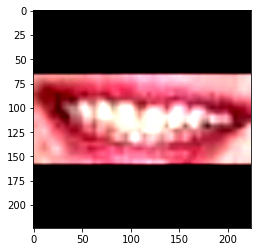

In [25]:
img =next(training_set)
#print(classes)

l=[]
for i, x in enumerate(classes):
    if img[1][0][i]==1 :
        l.append(x)

print("image labels:")
print(l)

img=img[0][0]  #first image
#print(img.shape)
# print(img)
print(np.amin(img.flatten()))
plt.imshow(img)
training_set.reset()

## 2- Model : VGG-16 with pre-trained weights of face recognition task

In [57]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False

model.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_2").trainable =True
model.get_layer("conv5_3").trainable =True
model.get_layer("conv5_1").trainable =True


#adding output layers
model.add(Flatten())

model.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(5, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [58]:
initial_learning_rate = 0.0002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model.fit(x=training_set, validation_data=valid_set, epochs=25 , shuffle =True)


Epoch 1/25
83/83 [==============================] - 18s 198ms/step - loss: 2.9819 - binary_accuracy: 0.5030 - val_loss: 2.6217 - val_binary_accuracy: 0.4553
Epoch 2/25
83/83 [==============================] - 16s 191ms/step - loss: 2.2708 - binary_accuracy: 0.5789 - val_loss: 2.2963 - val_binary_accuracy: 0.5868
Epoch 3/25
83/83 [==============================] - 16s 191ms/step - loss: 1.7878 - binary_accuracy: 0.6480 - val_loss: 1.7163 - val_binary_accuracy: 0.6026
Epoch 4/25
83/83 [==============================] - 16s 191ms/step - loss: 1.4620 - binary_accuracy: 0.6872 - val_loss: 1.5063 - val_binary_accuracy: 0.5974
Epoch 5/25
83/83 [==============================] - 16s 191ms/step - loss: 1.2250 - binary_accuracy: 0.7188 - val_loss: 1.2497 - val_binary_accuracy: 0.6658
Epoch 6/25
83/83 [==============================] - 16s 195ms/step - loss: 1.0546 - binary_accuracy: 0.7499 - val_loss: 1.0759 - val_binary_accuracy: 0.6789
Epoch 7/25
83/83 [==============================] - 16s 19

## Plotting Diagnostic curves

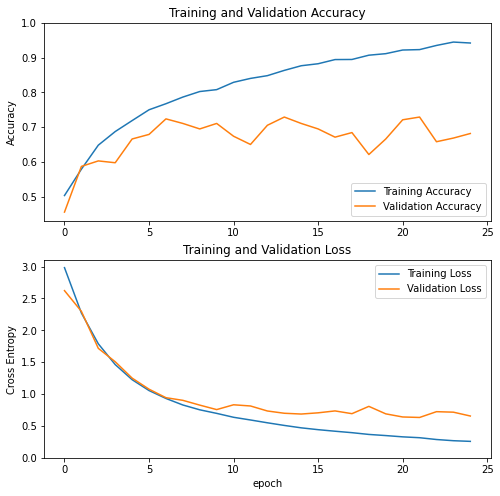

In [59]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [60]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)

,0,1,2,3,4
0,0.0,1.0,1.0,0.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
343,0.0,0.0,0.0,0.0,0.0
344,0.0,1.0,1.0,1.0,1.0
345,0.0,0.0,0.0,0.0,0.0
346,0.0,1.0,1.0,0.0,1.0


In [61]:
from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.80      0.60      0.68        92
        16-Incisal Embrasure       0.76      0.85      0.80       192
                     4-color       0.69      0.78      0.73       188
                  52-Crooked       0.65      0.51      0.57       108
41-Central Incisor W/H Ratio       0.66      0.84      0.74       196

                   micro avg       0.70      0.75      0.73       776
                   macro avg       0.71      0.72      0.71       776
                weighted avg       0.71      0.75      0.72       776
                 samples avg       0.56      0.57      0.54       776



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true labels : 41-Central Incisor W/H Ratio
predicted labels : 41-Central Incisor W/H Ratio


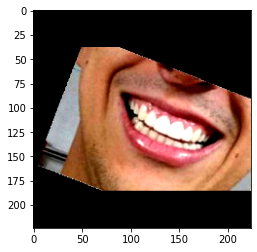

In [62]:
n=120
# output sample
true_labels=[]
pred_labels = []

for y ,z  in zip(y_test,y_pred):
    true =[]
    pred =[]
    for i, x in enumerate(classes):
        if y[i]==1 :
            true.append(x)
            
        if z[i]==1 :
            pred.append(x)
    true_labels.append(", ".join(true))
    pred_labels.append(", ".join(pred))
        
#print(test_set.index_array)
print("true labels : "+true_labels[n])
print("predicted labels : "+pred_labels[n])

plt.imshow(X_test[n])

#['gummy', 'golden_proportion ', 'gap', 'crowding', 'incisal embrassure ', 'color', 'Central line', 'Crooked', 'Central Incisor W/H Ratio', 'Black triangle', 'perfect']

In [32]:
model.save("vgg_teeth.h5")